In [1]:

from pathlib import Path
from IPython.display import HTML, display
css = Path("../../../css/rtl.css").read_text(encoding="utf-8")
display(HTML(f"<style>{css}</style>"))

# فصل ۳ — تحلیل اکتشافی داده‌ها (EDA)
## درس ۱۰: گزارش‌دهی EDA (روایت‌ها، فرض‌ها و بینش‌های عملی)

### این نوت‌بوک چه چیزی یاد می‌دهد؟

بیشتر نوت‌بوک‌های EDA شبیه دفترچه یادداشت تحلیل‌گر هستند: نمودارهای زیاد، ایده‌های نیمه‌تمام و پشتیبانی تصمیم کم.

اما **گزارش EDA** یک مصنوع تصمیم‌سازی است و باید پاسخ دهد:

- **چه چیزی در داده‌ها درست است (شواهد)؟**
- **چه معنایی می‌تواند داشته باشد (تفسیر + عدم‌قطعیت)؟**
- **گام بعدی چیست (اقدام + اعتبارسنجی)؟**

### خروجی‌های یادگیری

پس از پایان این نوت‌بوک باید بتوانید:
1. گزارش EDA ساختارمند بسازید (خلاصه مدیریتی → نمای کلی → یافته‌ها → ریسک/فرض‌ها → گام‌های بعدی).
2. خروجی‌های EDA را به روایت‌های قابل اقدام تبدیل کنید.
3. فرقِ مشاهده/فرضیه/پیشنهاد را روشن نگه دارید.
4. عدم‌قطعیت را با زبان ساده و بازه‌های کمی بیان کنید.
5. یک گزارش‌ساز ساده و قابل استفاده مجدد در پایتون بسازید.

### داده‌های استفاده‌شده

- `../../../Datasets/Regression/NYC_Collisions.csv`
- `../../../Datasets/Classification/Fast_Food_Restaurants_US.csv`

---

## ۰) قرارداد گزارش‌دهی EDA

قبل از نوشتن گزارش، این موارد را مشخص کنید:

- **مخاطب:** مدیران / محصول / علم داده
- **هدف:** این گزارش چه تصمیمی را پشتیبانی می‌کند؟
- **دامنه:** بازه زمانی، فیلترها، نمونه‌گیری
- **استاندارد شواهد:** هر ادعا باید پشتوانه (جدول/نمودار/معیار) داشته باشد

---

## ۱) مدل نوشتن: مشاهده → پیامد → پیشنهاد

یک یافته خوب معمولاً این سه جزء را دارد:
1) مشاهده کمی‌شده
2) پیامد مرتبط با هدف
3) پیشنهاد اقدام + روش اعتبارسنجی

In [2]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 80)
pd.set_option("display.width", 180)

DATASET_COLLISIONS = r"../../../Datasets/Regression/NYC_Collisions.csv"
DATASET_FASTFOOD = r"../../../Datasets/Classification/Fast_Food_Restaurants_US.csv"

def read_csv_strict(path, nrows=None):
    # در ساختار این ریپو، فایل‌های CSV باید در مسیر داده‌شده موجود باشند.
    return pd.read_csv(path, nrows=nrows, low_memory=False)

def pct(x):
    return 100.0 * x

def summarize_missing(df):
    m = df.isna().mean().sort_values(ascending=False)
    out = pd.DataFrame({"missing_rate": m, "missing_pct": pct(m)})
    return out[out["missing_rate"] > 0]

def df_overview(df, name="dataset"):
    return pd.DataFrame({
        "dataset": [name],
        "rows": [len(df)],
        "cols": [df.shape[1]],
        "memory_mb": [df.memory_usage(deep=True).sum() / (1024**2)],
        "duplicate_rows": [int(df.duplicated().sum())],
    })

def parse_datetime(date_series, time_series=None):
    if time_series is None:
        return pd.to_datetime(date_series, errors="coerce")
    return pd.to_datetime(date_series.astype(str) + " " + time_series.astype(str), errors="coerce")

## ۲) بارگذاری داده و تعیین دامنه

برای پاسخگو بودن نوت‌بوک، از هر فایل تا سقف مشخصی ردیف می‌خوانیم.

In [3]:

NROWS_COLLISIONS = 200_000
NROWS_FASTFOOD = 200_000

coll = read_csv_strict(DATASET_COLLISIONS, nrows=NROWS_COLLISIONS)
ff = read_csv_strict(DATASET_FASTFOOD, nrows=NROWS_FASTFOOD)

pd.concat([df_overview(coll, "NYC_Collisions"), df_overview(ff, "Fast_Food_Restaurants_US")], ignore_index=True)

,dataset,rows,cols,memory_mb,duplicate_rows
0,NYC_Collisions,125445,20,64.418501,0
1,Fast_Food_Restaurants_US,10000,11,5.729819,0


In [4]:
coll.head()

,COLLISION_ID,ACCIDENT_DATE,ACCIDENT_TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,STREET NAME,CROSS STREET NAME,FULL ADDRESS,VEHICLE TYPE,CONTRIBUTING FACTOR,PERSONS INJURED,PERSONS KILLED,PEDESTRIANS INJURED,PEDESTRIANS KILLED,CYCLIST INJURED,CYCLIST KILLED,MOTORIST INJURED,MOTORIST KILLED
0,4380785,2021-01-01,00:00:00,QUEENS,11434.0,40.664536,-73.77314,NaN,NaN,145-8 175 STREET,Station Wagon/Sport Utility Vehicle,Unspecified,0.0,0,0,0,0,0,0,0
1,4380974,2021-01-01,00:00:00,QUEENS,11355.0,40.754375,-73.82340,BEECH AVENUE,KISSENA BOULEVARD,NaN,Sedan,Unspecified,0.0,0,0,0,0,0,0,0
2,4381080,2021-01-01,00:00:00,BROOKLYN,11203.0,40.658295,-73.93109,UTICA AVENUE,WINTHROP STREET,NaN,Station Wagon/Sport Utility Vehicle,Driver Inattention/Distraction,1.0,0,0,0,0,0,1,0
3,4381095,2021-01-01,00:00:00,BROOKLYN,11212.0,40.661873,-73.92878,NaN,NaN,108 EAST 91 STREET,Sedan,Unspecified,0.0,0,0,0,0,0,0,0
4,4381962,2021-01-01,00:00:00,NaN,NaN,40.834198,-73.85169,WESTCHESTER AVENUE,NaN,NaN,Sedan,Unspecified,1.0,0,1,0,0,0,0,0


In [5]:
ff.head()

,Unnamed: 0,address,categories,city,country,latitude,longitude,name,postalCode,province,websites
0,0,800 N Canal Blvd,American Restaurant and Fast Food Restaurant,Thibodaux,US,29.814697,-90.814742,SONIC Drive In,70301,LA,https://locations.sonicdrivein.com/la/thibodau...
1,1,800 N Canal Blvd,Fast Food Restaurants,Thibodaux,US,29.814697,-90.814742,SONIC Drive In,70301,LA,https://locations.sonicdrivein.com/la/thibodau...
2,2,206 Wears Valley Rd,Fast Food Restaurant,Pigeon Forge,US,35.803788,-83.580553,Taco Bell,37863,TN,"http://www.tacobell.com,https://locations.taco..."
3,3,3652 Parkway,Fast Food,Pigeon Forge,US,35.782339,-83.551408,Arby's,37863,TN,"http://www.arbys.com,https://locations.arbys.c..."
4,4,2118 Mt Zion Parkway,Fast Food Restaurant,Morrow,US,33.562738,-84.321143,Steak 'n Shake,30260,GA,http://www.steaknshake.com/locations/23851-ste...


## ۳) نمای کلی داده: نوع ستون‌ها، گمشده‌ها، تکراری‌ها

In [6]:

schema_coll = coll.dtypes.astype(str).to_frame("dtype")
schema_ff = ff.dtypes.astype(str).to_frame("dtype")
schema_coll.head(25), schema_ff.head(25)

(                       dtype
 COLLISION_ID           int64
 ACCIDENT_DATE         object
 ACCIDENT_TIME         object
 BOROUGH               object
 ZIP CODE             float64
 LATITUDE             float64
 LONGITUDE            float64
 STREET NAME           object
 CROSS STREET NAME     object
 FULL ADDRESS          object
 VEHICLE TYPE          object
 CONTRIBUTING FACTOR   object
 PERSONS INJURED      float64
 PERSONS KILLED         int64
 PEDESTRIANS INJURED    int64
 PEDESTRIANS KILLED     int64
 CYCLIST INJURED        int64
 CYCLIST KILLED         int64
 MOTORIST INJURED       int64
 MOTORIST KILLED        int64,
               dtype
 Unnamed: 0    int64
 address      object
 categories   object
 city         object
 country      object
 latitude    float64
 longitude   float64
 name         object
 postalCode   object
 province     object
 websites     object)

In [7]:

missing_coll = summarize_missing(coll).head(15)
missing_ff = summarize_missing(ff).head(15)
missing_coll, missing_ff

(                     missing_rate  missing_pct
 FULL ADDRESS             0.730623    73.062298
 CROSS STREET NAME        0.536833    53.683287
 ZIP CODE                 0.345578    34.557774
 BOROUGH                  0.345466    34.546614
 STREET NAME              0.269385    26.938499
 LONGITUDE                0.088804     8.880386
 LATITUDE                 0.088804     8.880386
 VEHICLE TYPE             0.012141     1.214078
 CONTRIBUTING FACTOR      0.005030     0.503009
 PERSONS INJURED          0.000008     0.000797,
 Empty DataFrame
 Columns: [missing_rate, missing_pct]
 Index: [])

In [8]:

quality_summary = pd.DataFrame({
    "metric": [
        "collisions_missing_borough_pct",
        "collisions_missing_zip_pct",
        "collisions_duplicate_rows",
        "fastfood_duplicate_rows",
        "fastfood_missing_name_pct",
        "fastfood_missing_lat_pct",
        "fastfood_missing_lon_pct",
    ],
    "value": [
        float(pct(coll["BOROUGH"].isna().mean())) if "BOROUGH" in coll.columns else np.nan,
        float(pct(coll["ZIP CODE"].isna().mean())) if "ZIP CODE" in coll.columns else np.nan,
        int(coll.duplicated().sum()),
        int(ff.duplicated().sum()),
        float(pct(ff["name"].isna().mean())) if "name" in ff.columns else np.nan,
        float(pct(ff["latitude"].isna().mean())) if "latitude" in ff.columns else np.nan,
        float(pct(ff["longitude"].isna().mean())) if "longitude" in ff.columns else np.nan,
    ]
})
quality_summary

,metric,value
0,collisions_missing_borough_pct,34.546614
1,collisions_missing_zip_pct,34.557774
2,collisions_duplicate_rows,0.000000
3,fastfood_duplicate_rows,0.000000
4,fastfood_missing_name_pct,0.000000
5,fastfood_missing_lat_pct,0.000000
6,fastfood_missing_lon_pct,0.000000


### تبدیل معیار کیفیت به زبان گزارش

به‌جای «BOROUGH گمشده ۱۸٪ است»، بهتر است بنویسید:
- «`BOROUGH` در ۱۸٪ رکوردها گم است؛ بنابراین مقایسه نواحی ممکن است مشروط باشد. ما گروه ‘Unknown’ را جداگانه گزارش می‌کنیم و الگوی گمشده‌ها را بررسی می‌کنیم.»

## ۴) مثال A: گزارش‌دهی برای تصادفات NYC

In [9]:

if {"ACCIDENT_DATE", "ACCIDENT_TIME"}.issubset(coll.columns):
    coll["accident_dt"] = parse_datetime(coll["ACCIDENT_DATE"], coll["ACCIDENT_TIME"])
elif "ACCIDENT_DATE" in coll.columns:
    coll["accident_dt"] = parse_datetime(coll["ACCIDENT_DATE"])
else:
    coll["accident_dt"] = pd.NaT

coll["accident_month"] = coll["accident_dt"].dt.to_period("M").astype(str)
coll["accident_dow"] = coll["accident_dt"].dt.day_name()
coll["accident_hour"] = coll["accident_dt"].dt.hour

inj = "PERSONS INJURED"
killed = "PERSONS KILLED"
for c in [inj, killed]:
    if c in coll.columns:
        coll[c] = pd.to_numeric(coll[c], errors="coerce")

coll[[ "accident_dt", "accident_month", "accident_dow", "accident_hour", inj, killed ]].head()

,accident_dt,accident_month,accident_dow,accident_hour,PERSONS INJURED,PERSONS KILLED
0,2021-01-01,2021-01,Friday,0,0.0,0
1,2021-01-01,2021-01,Friday,0,0.0,0
2,2021-01-01,2021-01,Friday,0,1.0,0
3,2021-01-01,2021-01,Friday,0,0.0,0
4,2021-01-01,2021-01,Friday,0,1.0,0


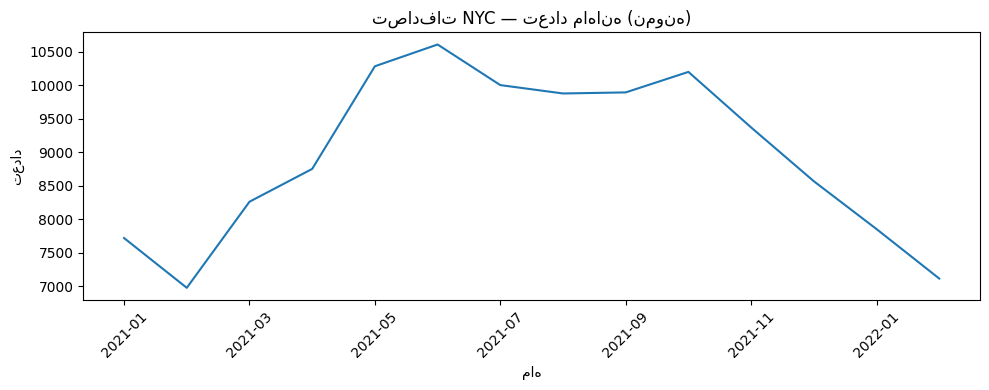

accident_month
2021-03     8259
2021-04     8749
2021-05    10281
2021-06    10606
2021-07    10000
2021-08     9875
2021-09     9891
2021-10    10197
2021-11     9368
2021-12     8565
2022-01     7851
2022-02     7112
dtype: int64

In [10]:

month_counts = coll.dropna(subset=["accident_dt"]).groupby("accident_month").size().sort_index()

plt.figure(figsize=(10, 4))
month_counts.plot()
plt.title("تصادفات NYC — تعداد ماهانه (نمونه)")
plt.xlabel("ماه")
plt.ylabel("تعداد")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

month_counts.tail(12)

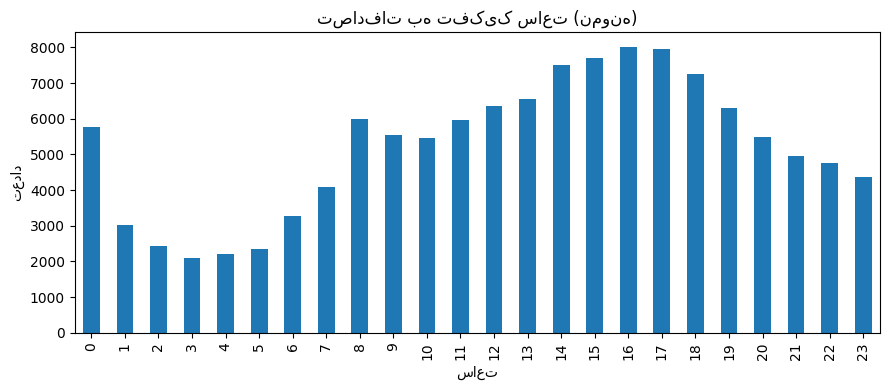

accident_hour
0    5779
1    3033
2    2441
3    2099
4    2197
Name: count, dtype: int64

In [11]:

hour_counts = coll["accident_hour"].value_counts(dropna=True).sort_index()

plt.figure(figsize=(9, 4))
hour_counts.plot(kind="bar")
plt.title("تصادفات به تفکیک ساعت (نمونه)")
plt.xlabel("ساعت")
plt.ylabel("تعداد")
plt.tight_layout()
plt.show()

hour_counts.head()

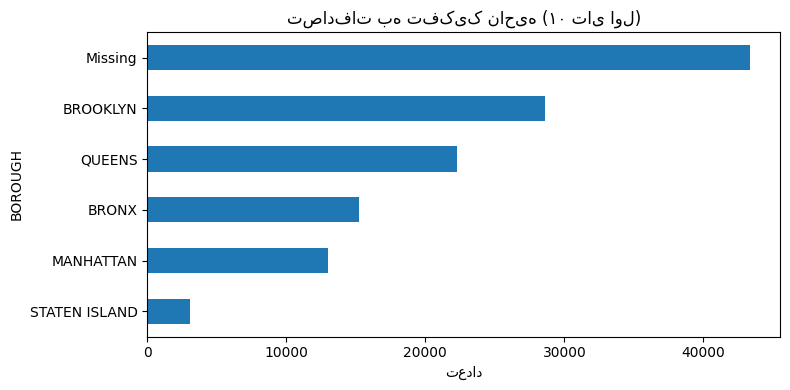

In [12]:

if "BOROUGH" in coll.columns:
    borough_counts = coll["BOROUGH"].fillna("Missing").value_counts()
    plt.figure(figsize=(8, 4))
    borough_counts.head(10).sort_values().plot(kind="barh")
    plt.title("تصادفات به تفکیک ناحیه (۱۰ تای اول)")
    plt.xlabel("تعداد")
    plt.tight_layout()
    plt.show()
    borough_counts.head(10)
else:
    "ستون BOROUGH پیدا نشد."

In [13]:

sev_cols = [c for c in [inj, killed] if c in coll.columns]
coll[sev_cols].describe(percentiles=[0.5, 0.9, 0.99]) if sev_cols else "ستون‌های شدت موجود نیست."

,PERSONS INJURED,PERSONS KILLED
count,125444.000000,125445.000000
mean,0.463617,0.002655
std,0.787200,0.053430
min,0.000000,0.000000
50%,0.000000,0.000000
90%,1.000000,0.000000
99%,3.000000,0.000000
max,18.000000,3.000000


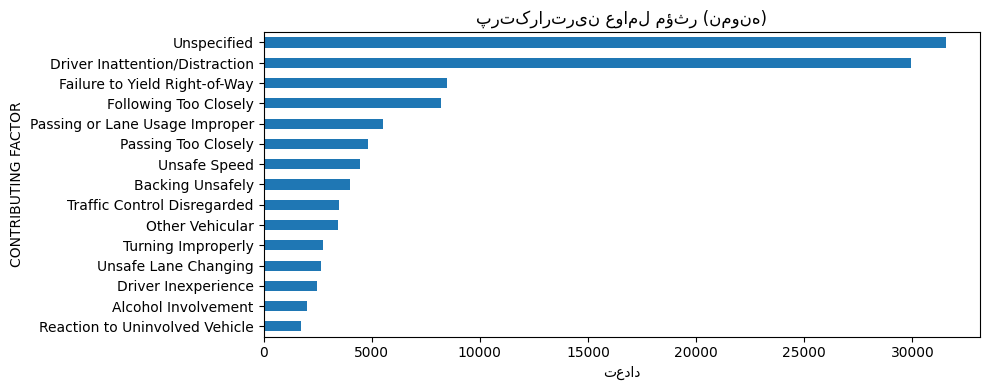

In [14]:

factor_col = "CONTRIBUTING FACTOR"
if factor_col in coll.columns:
    top_factors = coll[factor_col].fillna("Missing").value_counts().head(15)
    plt.figure(figsize=(10, 4))
    top_factors.sort_values().plot(kind="barh")
    plt.title("پرتکرارترین عوامل مؤثر (نمونه)")
    plt.xlabel("تعداد")
    plt.tight_layout()
    plt.show()
    top_factors
else:
    "ستون عامل مؤثر موجود نیست."

### یافته‌های آماده‌ی گزارش (متن نمونه)

- **یافته A1:** اوج تصادفات در ساعت‌های مشخصی است (نمودار ساعت).  
  **پیامد:** تمرکز منابع در ساعات اوج احتمالاً اثربخش‌تر است.  
  **پیشنهاد:** پروفایل ساعتی وزن‌دهی‌شده با مصدومیت بسازید و با تحلیل قبل/بعد اعتبارسنجی کنید.

- **یافته A2:** فیلدهای مکانی گمشده هستند (جدول گمشده‌ها).  
  **پیامد:** مقایسه نواحی ممکن است سوگیرانه باشد.  
  **پیشنهاد:** تحلیل سازوکار گمشده‌ها و گزارش گروه ‘Unknown’.

- **یافته A3:** شدت دنباله‌سنگین است (میانه در برابر P99).  
  **پیامد:** میانگین رخدادهای نادر را پنهان می‌کند.  
  **پیشنهاد:** معیارهای دنباله و طبقه‌بندی شدت را گزارش کنید.

## ۵) عدم‌قطعیت

یک نمونه‌ی کمی از بازه اطمینان:

$$
\bar{x} \pm z_{1-\alpha/2}\frac{s}{\sqrt{n}}
$$

In [15]:

if inj in coll.columns:
    x = coll[inj].fillna(0).to_numpy()
    n = len(x)
    mean = float(x.mean())
    std = float(x.std(ddof=1))
    z = 1.96
    half = z * std / np.sqrt(n)
    pd.DataFrame({"metric": ["mean_injuries", "ci_low", "ci_high", "n"], "value": [mean, mean-half, mean+half, n]})
else:
    "ستون مصدومیت موجود نیست."

## ۶) مثال B: گزارش‌دهی برای داده‌های موجودیتی/مکانی (فست‌فود)

In [16]:

ff_overview = df_overview(ff, "Fast_Food_Restaurants_US")
ff_missing = summarize_missing(ff).head(20)
ff_overview, ff_missing

(                    dataset   rows  cols  memory_mb  duplicate_rows
 0  Fast_Food_Restaurants_US  10000    11   5.730083               0,
 Empty DataFrame
 Columns: [missing_rate, missing_pct]
 Index: [])

In [17]:

top_names = ff["name"].fillna("Missing").value_counts().head(10) if "name" in ff.columns else None
top_cats = ff["categories"].fillna("Missing").value_counts().head(10) if "categories" in ff.columns else None
top_names, top_cats

(name
 McDonald's         1898
 Taco Bell          1032
 Burger King         833
 Subway              776
 Arby's              663
 Wendy's             628
 Jack in the Box     330
 Pizza Hut           230
 Dairy Queen         218
 Domino's Pizza      215
 Name: count, dtype: int64,
 categories
 Fast Food Restaurant                                             3425
 Fast Food Restaurants                                            3406
 Fast Food                                                        1777
 Fast Food Restaurant and Burger Joint                             260
 Fast food restaurants                                             191
 Fast Food Restaurant and Mexican Restaurant                       132
 Fast Food Restaurant, American Restaurant, and Sandwich Place     101
 Fast Food Restaurant, Sandwich Place, and American Restaurant      65
 Sandwich Place and Fast Food Restaurant                            35
 Fast Food Restaurant and American Restaurant                    

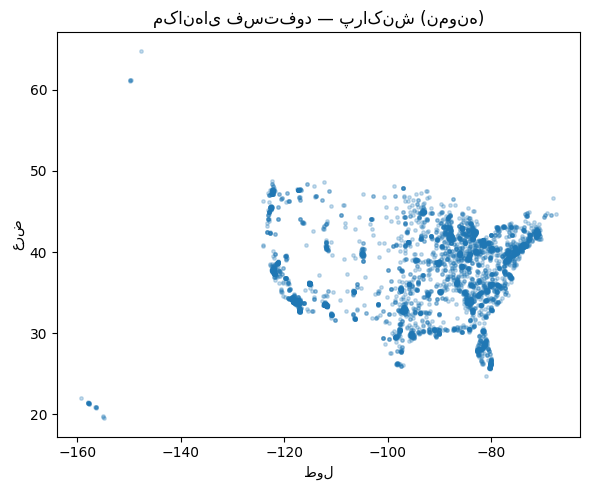

In [18]:

if {"latitude", "longitude"}.issubset(ff.columns):
    geo = ff[["latitude","longitude"]].dropna()
    sample = geo.sample(min(5000, len(geo)), random_state=42)
    plt.figure(figsize=(6, 5))
    plt.scatter(sample["longitude"], sample["latitude"], s=6, alpha=0.25)
    plt.title("مکان‌های فست‌فود — پراکنش (نمونه)")
    plt.xlabel("طول")
    plt.ylabel("عرض")
    plt.tight_layout()
    plt.show()
else:
    "مختصات موجود نیست."

In [19]:

if {"name","latitude","longitude"}.issubset(ff.columns):
    ff_key = ff.assign(
        name_n=ff["name"].astype(str).str.strip().str.lower(),
        lat_r=ff["latitude"].round(5),
        lon_r=ff["longitude"].round(5),
    ).dropna(subset=["lat_r","lon_r"])
    dup_counts = ff_key.groupby(["name_n","lat_r","lon_r"]).size().sort_values(ascending=False)
    dup_counts.head(15)
else:
    "ستون‌های لازم موجود نیست."

### مثال: نرمال‌سازی URL

In [20]:

import urllib.parse as ul

def normalize_url(u: str) -> str:
    if not isinstance(u, str):
        return ""
    u = u.strip()
    if not u:
        return ""
    parsed = ul.urlsplit(u)
    q = ul.parse_qsl(parsed.query, keep_blank_values=True)
    q = [(k, v) for (k, v) in q if not k.lower().startswith("utm_")]
    new_query = ul.urlencode(q)
    parsed2 = parsed._replace(query=new_query)
    return ul.urlunsplit(parsed2)

def split_and_normalize_urls(field: str):
    if not isinstance(field, str):
        return []
    parts = [p.strip() for p in field.split(",")]
    parts = [p for p in parts if p]
    return [normalize_url(p) for p in parts]

if "websites" in ff.columns:
    example = ff["websites"].dropna().iloc[0]
    example, split_and_normalize_urls(example)[:5]
else:
    "ستون websites موجود نیست."

### مثال: نگاشت taxonomy برای دسته‌ها

In [21]:

TAXONOMY = {
    "burger": ["burger", "hamburger"],
    "pizza": ["pizza"],
    "mexican": ["taco", "mexican", "burrito"],
    "coffee": ["coffee", "cafe"],
    "chicken": ["chicken", "fried chicken"],
    "ice_cream": ["ice cream", "dessert", "shake"],
}

def map_category(raw: str):
    if not isinstance(raw, str):
        return []
    s = raw.lower()
    tags = []
    for tag, keywords in TAXONOMY.items():
        if any(k in s for k in keywords):
            tags.append(tag)
    return tags

if "categories" in ff.columns:
    mapped = ff["categories"].fillna("").apply(map_category)
    coverage = (mapped.apply(len) > 0).mean()
    coverage, pct(coverage)
else:
    "ستون categories موجود نیست."

In [22]:

if "categories" in ff.columns:
    tag_counts = mapped.explode().value_counts().dropna()
    tag_counts.to_frame("count")
else:
    "نگاشت دسته‌ها محاسبه نشده است."

## ۷) خلاصه مدیریتی (تولیدشده)

In [23]:
from IPython.display import Markdown, display

def md_bullets_from_series(s, label, n=5):
    lines = [f"- **{label}:**"]
    for k, v in s.head(n).items():
        try:
            v_int = int(v)
            lines.append(f"  - {k}: {v_int:,}")
        except Exception:
            lines.append(f"  - {k}: {v}")
    return "\n".join(lines)

def collisions_headlines(df):
    h = {"rows": len(df)}

    if "accident_dt" in df.columns and df["accident_dt"].notna().any():
        h["date_min"] = str(df["accident_dt"].min())
        h["date_max"] = str(df["accident_dt"].max())

    if "BOROUGH" in df.columns:
        h["borough_missing_pct"] = float(df["BOROUGH"].isna().mean() * 100.0)
        h["top_boroughs"] = df["BOROUGH"].fillna("Missing").value_counts().head(5)

    if "CONTRIBUTING FACTOR" in df.columns:
        h["top_factors"] = df["CONTRIBUTING FACTOR"].fillna("Missing").value_counts().head(5)

    if "PERSONS INJURED" in df.columns:
        injured = df["PERSONS INJURED"].fillna(0)
        h["injury_involvement_pct"] = float((injured >= 1).mean() * 100.0)
        h["injured_p99"] = float(injured.quantile(0.99))

    return h

def render_collisions_exec_summary(df):
    h = collisions_headlines(df)

    bullets = []
    bullets.append(f"- **تعداد ردیف‌ها:** {h['rows']:,}")

    if "date_min" in h and "date_max" in h:
        bullets.append(f"- **بازه زمانی:** {h['date_min']} → {h['date_max']}")

    if "injury_involvement_pct" in h:
        bullets.append(f"- **درگیری با مصدومیت:** {h['injury_involvement_pct']:.2f}% رکوردها حداقل ۱ مصدوم دارند.")
    if "injured_p99" in h:
        bullets.append(f"- **دنباله (P99) مصدومیت‌ها:** {h['injured_p99']:.0f}")

    if "borough_missing_pct" in h:
        bullets.append(f"- **ریسک کلیدی:** گمشده‌ی `BOROUGH` = {h['borough_missing_pct']:.2f}%.")

    if "top_boroughs" in h:
        bullets.append(md_bullets_from_series(h["top_boroughs"], "بیشترین نواحی از نظر حجم"))

    if "top_factors" in h:
        bullets.append(md_bullets_from_series(h["top_factors"], "پرتکرارترین عوامل"))

    bullets.append("- **گام‌های بعدی:**")
    bullets.append("  - تحلیل گمشده‌های مکانی و گزارش گروه Unknown.")
    bullets.append("  - گزارش شدت با معیارهای دنباله و طبقه‌بندی شدت.")
    bullets.append("  - در صورت نیاز به نرخ ریسک، داده مواجهه (حجم ترافیک/جمعیت) را اضافه کنید.")

    display(Markdown("# خلاصه مدیریتی — تصادفات NYC (نمونه)\n\n" + "\n".join(bullets)))

def fastfood_headlines(df):
    h = {"rows": len(df)}
    h["duplicate_rows"] = int(df.duplicated().sum())

    if "name" in df.columns:
        h["missing_name_pct"] = float(df["name"].isna().mean() * 100.0)
        h["top_names"] = df["name"].fillna("Missing").value_counts().head(5)

    if "categories" in df.columns:
        h["top_category_strings"] = df["categories"].fillna("Missing").value_counts().head(5)

    if {"latitude", "longitude"}.issubset(df.columns):
        h["geo_complete_pct"] = float((~df[["latitude", "longitude"]].isna().any(axis=1)).mean() * 100.0)

    if "websites" in df.columns:
        h["missing_websites_pct"] = float(df["websites"].isna().mean() * 100.0)

    return h

def render_fastfood_exec_summary(df):
    h = fastfood_headlines(df)

    bullets = []
    bullets.append(f"- **تعداد ردیف‌ها:** {h['rows']:,}")
    bullets.append(f"- **ردیف‌های تکراری:** {h['duplicate_rows']:,}")

    if "geo_complete_pct" in h:
        bullets.append(f"- **کامل بودن مختصات:** {h['geo_complete_pct']:.2f}% دارای latitude و longitude هستند.")
    if "missing_name_pct" in h:
        bullets.append(f"- **گمشده‌ی `name`:** {h['missing_name_pct']:.2f}%.")

    if "missing_websites_pct" in h:
        bullets.append(f"- **گمشده‌ی `websites`:** {h['missing_websites_pct']:.2f}%.")

    if "top_names" in h:
        bullets.append(md_bullets_from_series(h["top_names"], "پرتکرارترین نام‌ها (خام)"))
    if "top_category_strings" in h:
        bullets.append(md_bullets_from_series(h["top_category_strings"], "پرتکرارترین رشته‌های دسته (خام)"))

    bullets.append("- **گام‌های بعدی:**")
    bullets.append("  - تعریف کلید مرجع موجودیت و حذف تکراری با نرمال‌سازی نام + خوشه‌بندی مکانی.")
    bullets.append("  - استانداردسازی دسته‌ها با taxonomy کنترل‌شده و پایش drift.")
    bullets.append("  - نرمال‌سازی وب‌سایت‌ها به فهرست URL تمیز.")

    display(Markdown("# خلاصه مدیریتی — فست‌فود (نمونه)\n\n" + "\n".join(bullets)))

render_collisions_exec_summary(coll)
render_fastfood_exec_summary(ff)


# خلاصه مدیریتی — تصادفات NYC (نمونه)

- **تعداد ردیف‌ها:** 125,445
- **بازه زمانی:** 2021-01-01 00:00:00 → 2022-02-28 23:37:00
- **درگیری با مصدومیت:** 34.63% رکوردها حداقل ۱ مصدوم دارند.
- **دنباله (P99) مصدومیت‌ها:** 3
- **ریسک کلیدی:** گمشده‌ی `BOROUGH` = 34.55%.
- **بیشترین نواحی از نظر حجم:**
  - Missing: 43,337
  - BROOKLYN: 28,573
  - QUEENS: 22,267
  - BRONX: 15,211
  - MANHATTAN: 13,002
- **پرتکرارترین عوامل:**
  - Unspecified: 31,550
  - Driver Inattention/Distraction: 29,923
  - Failure to Yield Right-of-Way: 8,503
  - Following Too Closely: 8,214
  - Passing or Lane Usage Improper: 5,533
- **گام‌های بعدی:**
  - تحلیل گمشده‌های مکانی و گزارش گروه Unknown.
  - گزارش شدت با معیارهای دنباله و طبقه‌بندی شدت.
  - در صورت نیاز به نرخ ریسک، داده مواجهه (حجم ترافیک/جمعیت) را اضافه کنید.

# خلاصه مدیریتی — فست‌فود (نمونه)

- **تعداد ردیف‌ها:** 10,000
- **ردیف‌های تکراری:** 0
- **کامل بودن مختصات:** 100.00% دارای latitude و longitude هستند.
- **گمشده‌ی `name`:** 0.00%.
- **گمشده‌ی `websites`:** 0.00%.
- **پرتکرارترین نام‌ها (خام):**
  - McDonald's: 1,898
  - Taco Bell: 1,032
  - Burger King: 833
  - Subway: 776
  - Arby's: 663
- **پرتکرارترین رشته‌های دسته (خام):**
  - Fast Food Restaurant: 3,425
  - Fast Food Restaurants: 3,406
  - Fast Food: 1,777
  - Fast Food Restaurant and Burger Joint: 260
  - Fast food restaurants: 191
- **گام‌های بعدی:**
  - تعریف کلید مرجع موجودیت و حذف تکراری با نرمال‌سازی نام + خوشه‌بندی مکانی.
  - استانداردسازی دسته‌ها با taxonomy کنترل‌شده و پایش drift.
  - نرمال‌سازی وب‌سایت‌ها به فهرست URL تمیز.

In [24]:
# (این سلول عمداً خالی گذاشته شده است.)
# خلاصه‌های مدیریتی در سلول قبلی چاپ شده‌اند.


## ۸) بینش‌های عملی به‌عنوان تحویل‌دادنی

In [25]:

actions = pd.DataFrame([
    {
        "Action": "بررسی الگوی گمشده‌های BOROUGH/ZIP و تعریف سیاست گزارش‌دهی جغرافیای نامشخص.",
        "Owner": "تحلیل / مهندسی داده",
        "Expected impact": "کاهش ریسک سوگیری؛ بهبود تفسیرپذیری.",
        "Validation": "گمشده‌ها در زمان/پروکسی‌های مکانی؛ تحلیل حساسیت."
    },
    {
        "Action": "طبقه‌بندی شدت مصدومیت و پایش معیارهای دنباله (P90/P99).",
        "Owner": "تحلیل",
        "Expected impact": "اولویت‌دهی بهتر برای رخدادهای پرشدت.",
        "Validation": "پایداری در طول ماه‌ها و پس از مداخلات."
    },
    {
        "Action": "حذف تکراری مکان‌های رستوران و انتشار جدول مرجع.",
        "Owner": "مهندسی داده",
        "Expected impact": "جلوگیری از شمارش بادکرده و تحلیل پوشش غلط.",
        "Validation": "ممیزی دستی خوشه‌ها و سنجش خطا."
    },
])
actions

,Action,Owner,Expected impact,Validation
0,بررسی الگوی گمشده‌های BOROUGH/ZIP و تعریف سیاس...,تحلیل / مهندسی داده,کاهش ریسک سوگیری؛ بهبود تفسیرپذیری.,گمشده‌ها در زمان/پروکسی‌های مکانی؛ تحلیل حساسیت.
1,طبقه‌بندی شدت مصدومیت و پایش معیارهای دنباله (...,تحلیل,اولویت‌دهی بهتر برای رخدادهای پرشدت.,پایداری در طول ماه‌ها و پس از مداخلات.
2,حذف تکراری مکان‌های رستوران و انتشار جدول مرجع.,مهندسی داده,جلوگیری از شمارش بادکرده و تحلیل پوشش غلط.,ممیزی دستی خوشه‌ها و سنجش خطا.


## ۹) فرض‌ها و محدودیت‌ها

In [26]:

assumptions = pd.DataFrame([
    {"Dataset": "تصادفات NYC", "Assumption": "زمان‌ها به‌صورت سازگار ثبت شده‌اند.", "Status": "نامشخص", "Verification": "بررسی ناهنجاری‌ها به تفکیک ساعت/ناحیه."},
    {"Dataset": "تصادفات NYC", "Assumption": "گمشده‌های مکانی سوگیرانه نیستند.", "Status": "نامشخص", "Verification": "تحلیل گمشده‌ها در زمان و بر اساس مختصات."},
    {"Dataset": "فست‌فود", "Assumption": "ردیف‌ها به مکان‌های یکتا قابل تبدیل‌اند.", "Status": "نامشخص", "Verification": "خوشه‌بندی مکانی + تطبیق متن و ممیزی دستی."},
])
assumptions

,Dataset,Assumption,Status,Verification
0,تصادفات NYC,زمان‌ها به‌صورت سازگار ثبت شده‌اند.,نامشخص,بررسی ناهنجاری‌ها به تفکیک ساعت/ناحیه.
1,تصادفات NYC,گمشده‌های مکانی سوگیرانه نیستند.,نامشخص,تحلیل گمشده‌ها در زمان و بر اساس مختصات.
2,فست‌فود,ردیف‌ها به مکان‌های یکتا قابل تبدیل‌اند.,نامشخص,خوشه‌بندی مکانی + تطبیق متن و ممیزی دستی.


## ۱۰) چک‌لیست و تمرین‌ها

**چک‌لیست**
- هدف و دامنه روشن است
- هر ادعا شواهد دارد
- ریسک‌ها (گمشده/تکراری/نشت) گفته شده‌اند
- هر یافته یک گام بعدی با اعتبارسنجی دارد

**تمرین‌ها**
1) خلاصه مدیریتی ۵ بولتی بنویسید.  
2) شدت را طبقه‌بندی کنید و یک یافته بنویسید.  
3) حذف تکراری فست‌فود را توسعه دهید.  
4) taxonomy را توسعه دهید و پوشش را گزارش کنید.

---

## ۱۲) تبدیل EDA به روایت: ادعا → شواهد → قیدها → تصمیم

یک گزارش وقتی متقاعدکننده است که منطق را شفاف کند:

1) **ادعا:** جمله‌ی اصلی که می‌خواهید خواننده بپذیرد  
2) **شواهد:** نمودار/جدول/معیارهایی که ادعا را پشتیبانی می‌کنند  
3) **قیدها:** عدم‌قطعیت، محدودیت‌ها و ریسک‌های کیفیت داده  
4) **درخواست تصمیم:** اقدام بعدی و معیار موفقیت  

### الگوی نوشتن

- **ادعا:** ...
- **شواهد:** ...
- **قیدها:** ...
- **درخواست تصمیم:** ...

### ضدالگوها

- گزارش بدون عدد و کمیت
- «داده‌ها نشان می‌دهد…» بدون اشاره به سند
- «اثبات می‌کند…» در تحلیل همبستگی
- پیشنهاد بدون مالک و برنامه اعتبارسنجی

### مثال (تصادفات)

- **ادعا:** تصادفاتِ همراه با مصدومیت در بازه‌های زمانی مشخصی متمرکز هستند.
- **شواهد:** نمودار ساعت و جدول نرخ مصدومیت بر حسب ساعت/روز.
- **قیدها:** مخرج‌های مواجهه (حجم ترافیک) موجود نیست؛ بنابراین شمارش‌ها «نرخ بر حسب وسیله‌نقلیه-مایل» نیستند.
- **درخواست تصمیم:** برای ساعات اوج یک مداخله پایلوت اجرا کنید و با تحلیل قبل/بعد (با وزن‌دهی به شدت) ارزیابی کنید.

### مثال (مکانی/موجودیتی)

- **ادعا:** ساخت جدول مکان‌های مرجع ممکن است، اما نیاز به حذف تکراری و نگاشت taxonomy دارد.
- **شواهد:** شمارش کلیدهای تکراری (نام نرمال + مختصات گرد شده) و پوشش نگاشت دسته‌ها.
- **قیدها:** دسته‌های متنی پر نویز هستند و نگاشت نیاز به حکمرانی و نسخه‌بندی دارد.
- **درخواست تصمیم:** کلید یکتای v1 بسازید، جدول مرجع منتشر کنید و خوشه‌های مبهم را ممیزی انسانی کنید.

---

## ۱۳) فرض‌ها: چگونه بنویسیم تا قابل اعتبارسنجی باشند؟

فرض‌ها «عذرخواهی» نیستند؛ گزاره‌های قابل آزمون‌اند.

### انواع رایج فرض

1) **تعریف** (معنای ستون)  
2) **اندازه‌گیری** (چگونه ثبت شده)  
3) **پوشش/نمونه‌گیری**  
4) **گمشده‌ها**  
5) **تجمیع** (ماهانه/هفتگی و …)

### یک فرضِ قوی باید چک داشته باشد

- **فرض:** ...
- **اهمیت:** ...
- **اعتبارسنجی:** ...
- **برنامه جایگزین:** اگر نقض شد چه می‌کنیم؟

In [27]:
# کمک‌تابع برای تبدیل جدول به Markdown (بدون وابستگی اضافه)
from IPython.display import Markdown, display

def _escape_md(x):
    s = str(x)
    s = s.replace("\n", " ")
    s = s.replace("|", r"\|")
    return s

def df_to_markdown_str(df, max_rows=20):
    d = df.copy()
    if len(d) > max_rows:
        d = d.head(max_rows)

    cols = list(d.columns)
    lines = []
    lines.append("| " + " | ".join(map(str, cols)) + " |")
    lines.append("| " + " | ".join(["---"] * len(cols)) + " |")

    for _, row in d.iterrows():
        vals = [_escape_md(v) for v in row.tolist()]
        lines.append("| " + " | ".join(vals) + " |")

    return "\n".join(lines)

def df_to_markdown(df, title=None, max_rows=20):
    md_text = ""
    if title:
        md_text += f"### {title}\n\n"
    md_text += df_to_markdown_str(df, max_rows=max_rows)
    display(Markdown(md_text))

df_to_markdown(assumptions, title="ثبت فرض‌ها (نمونه)", max_rows=50)


### ثبت فرض‌ها (نمونه)

| Dataset | Assumption | Status | Verification |
| --- | --- | --- | --- |
| تصادفات NYC | زمان‌ها به‌صورت سازگار ثبت شده‌اند. | نامشخص | بررسی ناهنجاری‌ها به تفکیک ساعت/ناحیه. |
| تصادفات NYC | گمشده‌های مکانی سوگیرانه نیستند. | نامشخص | تحلیل گمشده‌ها در زمان و بر اساس مختصات. |
| فست‌فود | ردیف‌ها به مکان‌های یکتا قابل تبدیل‌اند. | نامشخص | خوشه‌بندی مکانی + تطبیق متن و ممیزی دستی. |

---

## ۱۴) امتیازدهی به اقدام‌پذیری: اثر × اطمینان ÷ تلاش

برای پاسخ به «اول کدام کار را انجام دهیم؟» می‌توانید از یک مدل ساده استفاده کنید:

$$
\text{score} = \frac{\text{impact} \times \text{confidence}}{\text{effort}}
$$

هر بُعد روی مقیاس ۱ تا ۵ امتیاز می‌گیرد.

In [28]:

actions_scored = actions.copy()
actions_scored["Impact (1-5)"] = [5, 4, 5, 4][:len(actions_scored)]
actions_scored["Confidence (1-5)"] = [3, 4, 3, 3][:len(actions_scored)]
actions_scored["Effort (1-5)"] = [2, 2, 4, 3][:len(actions_scored)]

actions_scored["PriorityScore"] = (actions_scored["Impact (1-5)"] * actions_scored["Confidence (1-5)"]) / actions_scored["Effort (1-5)"]
actions_scored.sort_values("PriorityScore", ascending=False)

,Action,Owner,Expected impact,Validation,Impact (1-5),Confidence (1-5),Effort (1-5),PriorityScore
1,طبقه‌بندی شدت مصدومیت و پایش معیارهای دنباله (...,تحلیل,اولویت‌دهی بهتر برای رخدادهای پرشدت.,پایداری در طول ماه‌ها و پس از مداخلات.,4,4,2,8.00
0,بررسی الگوی گمشده‌های BOROUGH/ZIP و تعریف سیاس...,تحلیل / مهندسی داده,کاهش ریسک سوگیری؛ بهبود تفسیرپذیری.,گمشده‌ها در زمان/پروکسی‌های مکانی؛ تحلیل حساسیت.,5,3,2,7.50
2,حذف تکراری مکان‌های رستوران و انتشار جدول مرجع.,مهندسی داده,جلوگیری از شمارش بادکرده و تحلیل پوشش غلط.,ممیزی دستی خوشه‌ها و سنجش خطا.,5,3,4,3.75


---

## ۱۵) تعمیق تحلیل تصادفات: طبقه‌بندی شدت و مقایسه گروه‌ها

برای گزارش‌دهی، طبقه‌بندی‌های قابل فهم مهم هستند.

### طبقه‌های شدت

- **بدون آسیب:** ۰ مصدوم و ۰ فوت  
- **مصدومیت:** ۱+ مصدوم و ۰ فوت  
- **فوت:** ۱+ فوت (صرف‌نظر از مصدومیت)

In [29]:

def severity_bucket(row):
    inj_v = row.get(inj, np.nan)
    kill_v = row.get(killed, np.nan)
    inj_v = 0 if pd.isna(inj_v) else float(inj_v)
    kill_v = 0 if pd.isna(kill_v) else float(kill_v)

    if kill_v >= 1:
        return "Fatal"
    if inj_v >= 1:
        return "Injury"
    return "No harm"

if inj in coll.columns and killed in coll.columns:
    coll["severity_bucket"] = coll.apply(severity_bucket, axis=1)
    coll["severity_bucket"].value_counts(dropna=False)
else:
    "ستون‌های شدت موجود نیست."

In [30]:

if "severity_bucket" in coll.columns:
    sev_month = coll.dropna(subset=["accident_month"]).groupby(["accident_month", "severity_bucket"]).size().unstack(fill_value=0).sort_index()
    sev_month.tail(12)
else:
    "severity_bucket محاسبه نشده است."

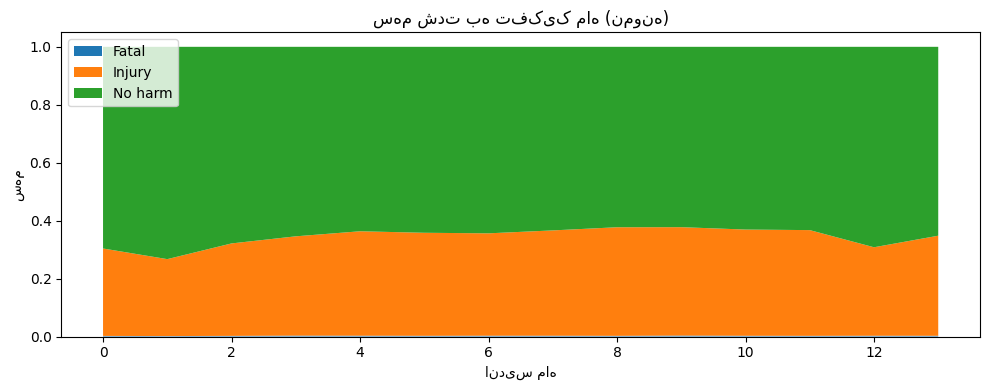

In [31]:

if "severity_bucket" in coll.columns:
    sev_share = sev_month.div(sev_month.sum(axis=1), axis=0)

    plt.figure(figsize=(10, 4))
    plt.stackplot(
        range(len(sev_share.index)),
        [sev_share[c].to_numpy() for c in sev_share.columns],
        labels=sev_share.columns
    )
    plt.title("سهم شدت به تفکیک ماه (نمونه)")
    plt.xlabel("اندیس ماه")
    plt.ylabel("سهم")
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()
else:
    "severity_bucket محاسبه نشده است."

### نرخ مصدومیت بر حسب ساعت و روز هفته (نقشه حرارتی)

$$
\text{injury\_rate}(h, d) = P(\text{injury} \ge 1 \mid \text{hour}=h, \text{day}=d)
$$

C:\Users\LENOVO.PIESC\AppData\Local\Temp\ipykernel_2016\1066827106.py:8: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  grid = tmp.pivot_table(index="accident_hour", columns="accident_dow", values="has_injury", aggfunc="mean")


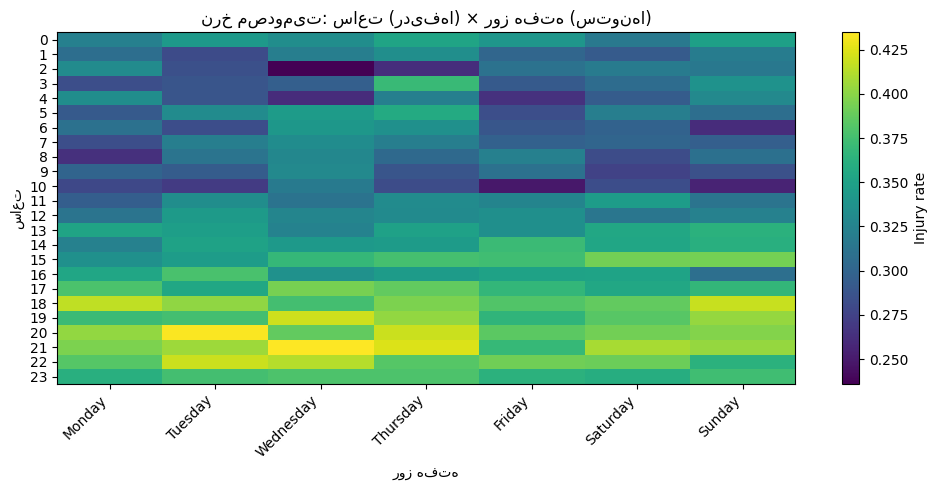

In [32]:

if inj in coll.columns:
    tmp = coll.dropna(subset=["accident_hour", "accident_dow"]).copy()
    tmp["has_injury"] = (tmp[inj].fillna(0) >= 1).astype(int)

    dow_order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
    tmp["accident_dow"] = pd.Categorical(tmp["accident_dow"], categories=dow_order, ordered=True)

    grid = tmp.pivot_table(index="accident_hour", columns="accident_dow", values="has_injury", aggfunc="mean")
    grid = grid.reindex(index=list(range(24)), columns=dow_order)

    plt.figure(figsize=(10, 5))
    plt.imshow(grid.to_numpy(), aspect="auto")
    plt.title("نرخ مصدومیت: ساعت (ردیف‌ها) × روز هفته (ستون‌ها)")
    plt.xlabel("روز هفته")
    plt.ylabel("ساعت")
    plt.xticks(range(len(dow_order)), dow_order, rotation=45, ha="right")
    plt.yticks(range(24), range(24))
    plt.colorbar(label="Injury rate")
    plt.tight_layout()
    plt.show()

    grid.head()
else:
    "ستون مصدومیت موجود نیست."

### مقایسه گروه‌ها با عدم‌قطعیت: بازه ویلسون

$$
\hat{p}_W = \frac{p + \frac{z^2}{2n}}{1 + \frac{z^2}{n}}, \quad
\text{half} = \frac{z}{1+\frac{z^2}{n}}\sqrt{\frac{p(1-p)}{n} + \frac{z^2}{4n^2}}
$$

In [33]:

def wilson_interval(k, n, z=1.96):
    if n <= 0:
        return (np.nan, np.nan, np.nan)
    p = k / n
    denom = 1.0 + (z**2)/n
    center = (p + (z**2)/(2*n)) / denom
    half = (z / denom) * math.sqrt((p*(1-p))/n + (z**2)/(4*n**2))
    return (center, max(0.0, center-half), min(1.0, center+half))

if "BOROUGH" in coll.columns and inj in coll.columns:
    g = coll.copy()
    g["has_injury"] = (g[inj].fillna(0) >= 1).astype(int)
    grp = g.groupby(g["BOROUGH"].fillna("Missing"))["has_injury"].agg(["sum","count"]).rename(columns={"sum":"k","count":"n"})
    out = grp.reset_index().rename(columns={"BOROUGH":"group"})
    out[["p_hat","ci_low","ci_high"]] = out.apply(lambda r: pd.Series(wilson_interval(int(r["k"]), int(r["n"]))), axis=1)
    out["p_hat_pct"] = pct(out["p_hat"])
    out["ci_low_pct"] = pct(out["ci_low"])
    out["ci_high_pct"] = pct(out["ci_high"])
    out.sort_values("p_hat", ascending=False).head(12)
else:
    "ستون‌های لازم موجود نیست."

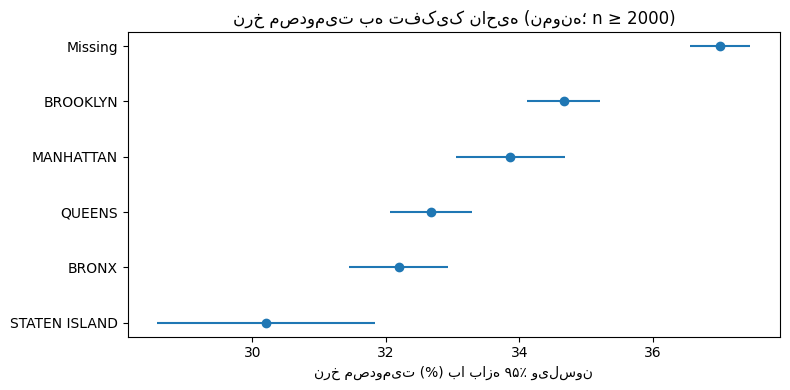

In [34]:

if "BOROUGH" in coll.columns and inj in coll.columns:
    plot_df = out[out["n"] >= 2000].sort_values("p_hat", ascending=False).head(10).copy()
    plot_df = plot_df.sort_values("p_hat")

    y = np.arange(len(plot_df))
    x = plot_df["p_hat_pct"].to_numpy()
    xerr = np.vstack([x - plot_df["ci_low_pct"].to_numpy(), plot_df["ci_high_pct"].to_numpy() - x])

    plt.figure(figsize=(8, 4))
    plt.errorbar(x, y, xerr=xerr, fmt="o")
    plt.yticks(y, plot_df["group"])
    plt.xlabel("نرخ مصدومیت (%) با بازه ۹۵٪ ویلسون")
    plt.title("نرخ مصدومیت به تفکیک ناحیه (نمونه؛ n ≥ 2000)")
    plt.tight_layout()
    plt.show()

    plot_df[["group","n","p_hat_pct","ci_low_pct","ci_high_pct"]]
else:
    "ستون‌های لازم موجود نیست."

### «خیابان‌های پرتکرار» لزوماً «خطرناک‌ترین خیابان‌ها» نیستند

شمارش به مواجهه حساس است. با این حال، «پرتکرارترین خیابان‌ها» می‌تواند نقطه شروع عملیاتی باشد اگر درست برچسب‌گذاری شود.

In [35]:

street_col = "STREET NAME"

def top_counts(series, n=15):
    return series.fillna("Missing").astype(str).str.strip().replace("", "Missing").value_counts().head(n)

if street_col in coll.columns:
    top_streets = top_counts(coll[street_col], 15)
    df_to_markdown(top_streets.reset_index().rename(columns={"index":"street","STREET NAME":"count"}), title="پرتکرارترین خیابان‌ها بر اساس شمارش (نمونه)")
else:
    "ستون خیابان موجود نیست."

### پرتکرارترین خیابان‌ها بر اساس شمارش (نمونه)

| count | count |
| --- | --- |
| Missing | 33793 |
| BELT PARKWAY | 2087 |
| LONG ISLAND EXPRESSWAY | 1154 |
| BROOKLYN QUEENS EXPRESSWAY | 1084 |
| FDR DRIVE | 1047 |
| BROADWAY | 1013 |
| ATLANTIC AVENUE | 959 |
| GRAND CENTRAL PKWY | 891 |
| MAJOR DEEGAN EXPRESSWAY | 853 |
| CROSS ISLAND PARKWAY | 840 |
| CROSS BRONX EXPY | 785 |
| LINDEN BOULEVARD | 706 |
| 3 AVENUE | 672 |
| VAN WYCK EXPWY | 653 |
| BRUCKNER EXPRESSWAY | 519 |

In [36]:

factor_col = "CONTRIBUTING FACTOR"
if factor_col in coll.columns and inj in coll.columns:
    tmp = coll.copy()
    tmp["has_injury"] = (tmp[inj].fillna(0) >= 1).astype(int)
    tmp[factor_col] = tmp[factor_col].fillna("Missing")

    top = tmp[factor_col].value_counts().head(12).index
    t2 = tmp[tmp[factor_col].isin(top)].groupby(["has_injury", factor_col]).size().unstack(fill_value=0)
    t2_share = t2.div(t2.sum(axis=1), axis=0)
    df_to_markdown(t2_share.reset_index().rename(columns={0:"No injury",1:"Injury"}), title="سهم عوامل به تفکیک مصدومیت (عوامل پرتکرار)")
else:
    "ستون‌های لازم موجود نیست."

### سهم عوامل به تفکیک مصدومیت (عوامل پرتکرار)

| has_injury | Backing Unsafely | Driver Inattention/Distraction | Failure to Yield Right-of-Way | Following Too Closely | Other Vehicular | Passing Too Closely | Passing or Lane Usage Improper | Traffic Control Disregarded | Turning Improperly | Unsafe Lane Changing | Unsafe Speed | Unspecified |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 0.0 | 0.04530780055737976 | 0.2597334510637124 | 0.04631494715929472 | 0.069217184956265 | 0.033387599679920534 | 0.06052537181645098 | 0.05783504870174664 | 0.021039706409867277 | 0.02535801992218758 | 0.025730526199608177 | 0.03476725255925609 | 0.32078309097431085 |
| 1.0 | 0.019162911894033983 | 0.301205146300418 | 0.1396775419358341 | 0.0867759622170349 | 0.027278649367569623 | 0.012322892351121004 | 0.036398675424786926 | 0.05333586667390478 | 0.02426578361652462 | 0.021035774387926823 | 0.05328158080451659 | 0.22525921502632865 |

---

## ۱۶) تعمیق تحلیل مکانی: خط لوله canonicalization

1) استانداردسازی متن  
2) چک‌های مکانی  
3) حذف تکراری (شباهت نام + نزدیکی مکانی)  
4) استانداردسازی دسته‌ها (taxonomy + نسخه‌بندی)  
5) انتشار جدول مرجع با کلید پایدار

In [37]:

def normalize_text(s):
    if not isinstance(s, str):
        return ""
    s = s.strip().lower()
    s = " ".join(s.split())
    return s

ff2 = ff.copy()

for col in ["name", "city", "province", "country", "categories"]:
    if col in ff2.columns:
        ff2[col + "_n"] = ff2[col].apply(normalize_text)

ff2[[c for c in ff2.columns if c.endswith("_n")]].head()

,name_n,city_n,province_n,country_n,categories_n
0,sonic drive in,thibodaux,la,us,american restaurant and fast food restaurant
1,sonic drive in,thibodaux,la,us,fast food restaurants
2,taco bell,pigeon forge,tn,us,fast food restaurant
3,arby's,pigeon forge,tn,us,fast food
4,steak 'n shake,morrow,ga,us,fast food restaurant


In [38]:

import urllib.parse as ul

def domain_from_url(u):
    if not isinstance(u, str):
        return ""
    u = u.strip()
    if not u:
        return ""
    if "://" not in u:
        u = "http://" + u
    try:
        return ul.urlsplit(u).netloc.lower()
    except Exception:
        return ""

if "websites" in ff2.columns:
    domains = ff2["websites"].fillna("").astype(str).apply(lambda s: [domain_from_url(x) for x in split_and_normalize_urls(s)])
    dom_counts = pd.Series([d for lst in domains for d in lst if d]).value_counts().head(20)
    df_to_markdown(dom_counts.reset_index().rename(columns={"index":"domain", 0:"count"}), title="دامنه‌های پرتکرار وب‌سایت (نمونه)")
else:
    "ستون websites موجود نیست."

### دامنه‌های پرتکرار وب‌سایت (نمونه)

| domain | count |
| --- | --- |
| www.mcdonalds.com | 1903 |
| mcdonalds.com | 1837 |
| locations.tacobell.com | 1036 |
| www.tacobell.com | 924 |
| www.bk.com | 768 |
| www.subway.com | 726 |
| locations.arbys.com | 704 |
| www.dominos.com | 649 |
| www.wendys.com | 624 |
| api.citygridmedia.com | 616 |
| www.arbys.com | 609 |
| subway.com | 492 |
| www.jackinthebox.com | 447 |
| locations.bk.com | 359 |
| www.chick-fil-a.com | 316 |
| tacobell.com | 299 |
| www.pizzahut.com | 266 |
| wendys.com | 223 |
| bk.com | 223 |
| arbys.com | 222 |

In [39]:

import difflib

def name_similarity(a, b):
    return difflib.SequenceMatcher(None, a, b).ratio()

if "ff_key" in globals() and {"name_n","lat_r","lon_r"}.issubset(ff_key.columns):
    candidates = dup_counts[dup_counts >= 3]
    if len(candidates) > 0:
        key = candidates.index[0]
        cluster = ff_key[(ff_key["name_n"] == key[0]) & (ff_key["lat_r"] == key[1]) & (ff_key["lon_r"] == key[2])]
        cluster[["name","address","city","province","latitude","longitude"]].head(10)
    else:
        "در نمونه خوشه با اندازه ≥ 3 پیدا نشد."
else:
    "ff_key محاسبه نشده است."

---

## ۱۷) تولیدکننده حداقلی گزارش (یافته‌های ساختارمند)

در تیم‌ها، استانداردسازی «شیء یافته» باعث مقیاس‌پذیری گزارش می‌شود.

In [40]:

from dataclasses import dataclass
from typing import List, Optional

@dataclass
class Finding:
    title: str
    observation: str
    evidence: str
    implication: str
    recommendation: str
    confidence: str = "Medium"
    owner: Optional[str] = None

def render_findings(findings: List[Finding], heading="Key Findings"):
    lines = [f"# {heading}", ""]
    for i, fnd in enumerate(findings, 1):
        lines.append(f"## {i}. {fnd.title}")
        lines.append(f"- **Observation:** {fnd.observation}")
        lines.append(f"- **Evidence:** {fnd.evidence}")
        lines.append(f"- **Implication:** {fnd.implication}")
        lines.append(f"- **Recommendation:** {fnd.recommendation}")
        lines.append(f"- **Confidence:** {fnd.confidence}")
        if fnd.owner:
            lines.append(f"- **Owner:** {fnd.owner}")
        lines.append("")
    return "\n".join(lines)

example_findings = []

if inj in coll.columns and "accident_hour" in coll.columns:
    hr = coll["accident_hour"].value_counts().sort_index()
    peak_hour = int(hr.idxmax())
    example_findings.append(
        Finding(
            title="تمرکز تصادفات در ساعات مشخص",
            observation=f"بیشترین حجم تصادف در نمونه حوالی ساعت {peak_hour} رخ می‌دهد.",
            evidence="نمودار ساعت؛ نقشه حرارتی نرخ مصدومیت (بخش ۱۵).",
            implication="می‌توان مداخلات را در بازه‌های اوج هدف‌گذاری کرد.",
            recommendation="فهرست ساعات اوجِ وزن‌دهی‌شده با مصدومیت بسازید و اثر مداخله را با قبل/بعد بسنجید.",
            confidence="Medium",
            owner="Analytics"
        )
    )

if "websites" in ff.columns:
    example_findings.append(
        Finding(
            title="نیاز به canonicalization برای تحلیل قابل اعتماد",
            observation="ردیف‌ها شامل تکراری و فیلدهای ناهمگن هستند.",
            evidence="کلیدهای تکراری؛ دامنه‌های وب‌سایت؛ پوشش نگاشت دسته‌ها (بخش ۱۶).",
            implication="کیفیت پایین موجودیت باعث روندهای ناپایدار و شمارش بادکرده می‌شود.",
            recommendation="جدول مرجع با کلید پایدار و قواعد ادغام + نگاشت نسخه‌بندی‌شده منتشر کنید.",
            confidence="Medium",
            owner="Data Engineering"
        )
    )

display(Markdown(render_findings(example_findings, heading="یافته‌های نمونه (پیش‌نویس)")))

# یافته‌های نمونه (پیش‌نویس)

## 1. تمرکز تصادفات در ساعات مشخص
- **Observation:** بیشترین حجم تصادف در نمونه حوالی ساعت 16 رخ می‌دهد.
- **Evidence:** نمودار ساعت؛ نقشه حرارتی نرخ مصدومیت (بخش ۱۵).
- **Implication:** می‌توان مداخلات را در بازه‌های اوج هدف‌گذاری کرد.
- **Recommendation:** فهرست ساعات اوجِ وزن‌دهی‌شده با مصدومیت بسازید و اثر مداخله را با قبل/بعد بسنجید.
- **Confidence:** Medium
- **Owner:** Analytics

## 2. نیاز به canonicalization برای تحلیل قابل اعتماد
- **Observation:** ردیف‌ها شامل تکراری و فیلدهای ناهمگن هستند.
- **Evidence:** کلیدهای تکراری؛ دامنه‌های وب‌سایت؛ پوشش نگاشت دسته‌ها (بخش ۱۶).
- **Implication:** کیفیت پایین موجودیت باعث روندهای ناپایدار و شمارش بادکرده می‌شود.
- **Recommendation:** جدول مرجع با کلید پایدار و قواعد ادغام + نگاشت نسخه‌بندی‌شده منتشر کنید.
- **Confidence:** Medium
- **Owner:** Data Engineering


---

## ۱۸) تمرین‌های تکمیلی

1) یک یافته را با الگوی ادعا/شواهد/قیدها/تصمیم بازنویسی کنید.  
2) برای مداخله ساعات اوج، معیار و طرح ارزیابی پیشنهاد دهید.  
3) شدت را به ۴ سطح گسترش دهید و سهم ماهانه را گزارش کنید.  
4) برای فست‌فود، کلید مرجع و قواعد ادغام تعریف کنید.  
5) نسخه‌بندی نگاشت taxonomy و پایش drift را طراحی کنید.

---

## ۱۹) اسکلت کامل گزارش EDA (قابل کپی برای پروژه‌ها)

این ساختار برای بسیاری از پروژه‌های ML جواب می‌دهد. می‌توانید آن را به‌صورت بخش Markdown در نوت‌بوک نگه دارید یا به گزارش جداگانه صادر کنید.

### ۱۹.۱ خلاصه مدیریتی (۵ تا ۱۰ بولت)

- **هدف:** چه تصمیمی را پشتیبانی می‌کند؟
- **دامنه:** داده‌ها، بازه زمانی، فیلترها، اندازه نمونه
- **یافته‌های اصلی (۳ تا ۵):** به فرم مشاهده → پیامد → پیشنهاد
- **ریسک‌های کلیدی:** کیفیت داده، سوگیری، نشت
- **درخواست تصمیم:** چه مواردی نیاز به نظر ذی‌نفع دارد؟

**بولت‌های نمونه (صرفاً نمونه‌نویسی):**
- «در نمونه، رخداد مصدومیت نادر است اما دنباله‌سنگین است (P99 بسیار بزرگ‌تر از میانه). پیشنهاد: گزارش بر اساس طبقه‌های شدت، نه فقط میانگین.»
- «فیلدهای جغرافیایی گمشده قابل توجه دارند؛ مقایسه نواحی باید گروه ‘Unknown’ و تحلیل حساسیت داشته باشد.»

### ۱۹.۲ زمینه و قاب‌بندی کسب‌وکار

- مشتری کیست؟
- معیار موفقیت چیست و چرا؟
- گزینه‌های تصمیم چیست؟
- محدودیت‌ها چیست؟

### ۱۹.۳ توصیف داده

- جدول‌ها و منابع
- کلیدها و دانه‌بندی (رویدادمحور/موجودیت‌محور)
- تعریف فیلدها (خصوصاً هدف و زمان)
- تناوب به‌روزرسانی

### ۱۹.۴ کیفیت داده و حکمرانی

- گمشده‌ها و پیامدشان
- تکراری‌ها (سطح ردیف و موجودیت)
- قواعد اعتبار
- منشأ فیلدها
- نکات حریم خصوصی (در صورت نیاز)

### ۱۹.۵ یافته‌ها (با شواهد)

برای هر یافته:
- نمودار/جدول،
- تفسیر،
- قیدها،
- و گام بعدی

### ۱۹.۶ ریسک‌ها و فرض‌ها

- ثبت فرض‌های قابل آزمون
- ثبت ریسک (شدت، احتمال، کاهش)
- محدودیت‌های شناخته‌شده

### ۱۹.۷ پیشنهادها و نقشه راه

- برنامه اقدام با مالک، تلاش و اثر
- برنامه اعتبارسنجی برای هر اقدام
- زمان‌بندی و وابستگی‌ها

### ۱۹.۸ پیوست

- نمودارهای اضافی
- فرهنگ داده
- نکات بازتولیدپذیری

---

## ۲۰) «کتابخانه» زبان آماده برای گزارش

### ۲۰.۱ زبان برای عدم‌قطعیت

- **اطمینان بالا:** «این الگو را در برش‌ها و بازه‌های زمانی مختلف به‌طور پایدار می‌بینیم.»
- **اطمینان متوسط:** «در نمونه فعلی این الگو مشاهده می‌شود؛ با فیلترهای دیگر ممکن است تغییر کند.»
- **اطمینان پایین:** «شواهد اولیه است و به دلیل گمشده‌ها/شمارش کم کامل نیست.»

### ۲۰.۲ زبان برای محدودیت‌ها

- «شمارش برابر با نرخ ریسک نیست؛ مخرج مواجهه (حجم ترافیک) موجود نیست.»
- «پوشش جغرافیایی کامل نیست؛ مقایسه مکانی ممکن است سوگیرانه باشد.»
- «دسته‌های متنی نیاز به حکمرانی دارند و نگاشت ممکن است در زمان تغییر کند.»

### ۲۰.۳ زبان برای پیشنهادها

- «این اقدام را به‌عنوان نسخه اول پیشنهاد می‌کنیم و با … اعتبارسنجی می‌کنیم.»
- «اگر این فرض نقض شود، … انجام می‌دهیم.»
- «برای عملیاتی‌سازی، تیم مالک تا بازه زمانی … اقدام می‌کند.»

### ۲۰.۴ پنج نمونه یافته کامل (الگو)

**یافته ۱ (تمرکز زمانی):**
- مشاهده: «حجم تصادف در ساعات مشخص اوج می‌گیرد؛ در نمونه، ساعت اوج X است.»
- شواهد: «نمودار ساعت؛ نقشه حرارتی نرخ مصدومیت.»
- پیامد: «مداخلات زمانی می‌تواند اهرم بالاتری داشته باشد.»
- پیشنهاد: «برای ساعات اوج پایلوت اجرا و با معیار وزن‌دهی‌شده ارزیابی کنید.»

**یافته ۲ (گمشده جغرافیایی):**
- مشاهده: «`BOROUGH` در Y٪ رکوردها گم است.»
- شواهد: «جدول گمشده‌ها + نمودار با گروه Unknown.»
- پیامد: «اگر گمشده‌ها با شدت مرتبط باشند، رتبه‌بندی سوگیرانه می‌شود.»
- پیشنهاد: «سازوکار گمشده‌ها و تحلیل حساسیت را منتشر کنید.»

**یافته ۳ (دنباله‌سنگین):**
- مشاهده: «P99 بسیار بزرگ‌تر از میانه است.»
- شواهد: «آمار توصیفی؛ توزیع طبقه‌های شدت.»
- پیامد: «میانگین رخدادهای پراثر را پنهان می‌کند.»
- پیشنهاد: «معیارهای دنباله و طبقه‌بندی شدت را گزارش کنید.»

**یافته ۴ (حذف تکراری موجودیت):**
- مشاهده: «با نام نرمال + مختصات گرد شده، کاندیدهای تکراری داریم.»
- شواهد: «جدول کلیدهای تکراری؛ بررسی خوشه نمونه.»
- پیامد: «شمارش و پوشش بادکرده می‌شود.»
- پیشنهاد: «جدول مرجع مکان با قواعد ادغام و ممیزی انسانی منتشر کنید.»

**یافته ۵ (حکمرانی taxonomy):**
- مشاهده: «رشته‌های دسته ناهمگون است و پوشش نگاشت کامل نیست.»
- شواهد: «پوشش نگاشت؛ رشته‌های پرتکرار بدون نگاشت.»
- پیامد: «روندها بدون لایه دسته‌بندی پایدار نیستند.»
- پیشنهاد: «نگاشت نسخه‌بندی‌شده بسازید و drift را پایش کنید.»

(در خروجی‌های خود X/Y را با اعداد واقعی جایگزین کنید.)

---

## ۲۱) صدور خروجی‌های گزارش

در بسیاری از تیم‌ها، نوت‌بوک محیط کاری است اما گزارش به یکی از شکل‌های زیر تحویل می‌شود:

- Markdown (برای GitHub/Docs)
- HTML (برای خوانندگان غیر فنی)
- داشبورد (برای پایش مستمر)

در اینجا یک پیش‌نویس Markdown ساده از یافته‌ها و جدول‌ها صادر می‌کنیم.

In [41]:
# صدور پیش‌نویس Markdown گزارش (بدون وابستگی‌های اختیاری)
import os
from datetime import datetime

report_lines = []
report_lines.append("# پیش‌نویس گزارش EDA — فصل ۳ درس ۱۰")
report_lines.append("")
report_lines.append(f"- Generated: {datetime.utcnow().strftime('%Y-%m-%d %H:%M UTC')}")
report_lines.append(f"- Datasets: {DATASET_COLLISIONS}, {DATASET_FASTFOOD}")
report_lines.append("")
report_lines.append("## خلاصه‌ها")
report_lines.append("")
report_lines.append("### تصادفات NYC (نمونه)")
report_lines.append("(خروجی‌های بخش‌های ۴، ۵ و ۱۵ را ببینید.)")
report_lines.append("")
report_lines.append("### فست‌فود (نمونه)")
report_lines.append("(خروجی‌های بخش‌های ۶ و ۱۶ را ببینید.)")
report_lines.append("")
report_lines.append("## یافته‌های کلیدی (پیش‌نویس)")
report_lines.append("")
report_lines.append(render_findings(example_findings, heading="یافته‌های کلیدی (پیش‌نویس)"))
report_lines.append("")
report_lines.append("## برنامه اقدام")
report_lines.append(df_to_markdown_str(actions_scored, max_rows=200))
report_lines.append("")
report_lines.append("## فرض‌ها")
report_lines.append(df_to_markdown_str(assumptions, max_rows=200))
report_lines.append("")

out_dir = "outputs"
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, "eda_report_draft_fa.md")

with open(out_path, "w", encoding="utf-8") as f:
    f.write("\n".join(report_lines))

out_path


C:\Users\LENOVO.PIESC\AppData\Local\Temp\ipykernel_2016\3459480874.py:8: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  report_lines.append(f"- Generated: {datetime.utcnow().strftime('%Y-%m-%d %H:%M UTC')}")


'outputs\\eda_report_draft_fa.md'

فایل `outputs/eda_report_draft_fa.md` را در ریپو باز کنید تا پیش‌نویس گزارش را ببینید.

برای رسمی‌تر کردن گزارش:
- جدول‌های مهم را مستقیم داخل گزارش بگذارید،
- لینک نمودارهای ذخیره‌شده را اضافه کنید،
- و هدر نسخه (تاریخ snapshot داده، نسخه کد، نویسنده) اضافه کنید.